# Gaussian Mixture Model Implementation

## 1. Data Structure

In [1]:
import numpy as np

In [2]:
class GaussianMixtureModel:    
    def __init__(self, num_components, data):
        num_samples, num_features = data.shape
        self.num_components = num_components
        random_coeffs = np.random.rand(self.num_components)
        self.mixing_coeffs = np.array(random_coeffs / random_coeffs.sum())
        sample_indices = np.random.choice(num_samples, self.num_components, replace=False)
        self.means = np.array(data[sample_indices])
        self.covariances = np.array([np.eye(num_features) for component_index in range(num_components)])

## 2. Fitting Function

In [3]:
from scipy.stats import multivariate_normal

In [4]:
def fit(mean, covariance, samples):
    mvn = multivariate_normal(mean, covariance, allow_singular=True)
    probabilities = mvn.pdf(samples)
    probabilities = np.atleast_1d(probabilities)
    return probabilities

## 3. Expectation step

In [5]:
def get_weighted_probabilities(mixture, samples):
    probs_given_model = [] 
    for component_index in range(mixture.num_components):
        probs = fit(mixture.means[component_index], mixture.covariances[component_index], samples)
        probs_given_model.append(probs)
    mixing_coeffs = mixture.mixing_coeffs.reshape(-1, 1)
    probs_given_model = np.array(probs_given_model)
    weighted_probs = mixing_coeffs * probs_given_model
    return weighted_probs

In [6]:
def expectation(mixture, samples):
    weighted_probs = get_weighted_probabilities(mixture, samples)
    sum_of_weighted_probs = np.sum(weighted_probs, axis=0)
    epsilon = 1e-9
    responsibilities = weighted_probs / (sum_of_weighted_probs + epsilon)
    return np.transpose(responsibilities)

## 4. Maximization step

In [7]:
def get_updated_mixing_coeffs(resp, samples):
    resp_total_per_model = np.sum(resp, axis=0)
    mixing_coeffs_updated = resp_total_per_model / len(samples)
    return mixing_coeffs_updated

In [8]:
def get_updated_means(resp, samples):
    means_updated = []
    for model_resp_row in np.transpose(resp):
        model_resp = model_resp_row.reshape(-1, 1)
        weighted_samples = model_resp * samples
        sum_of_weighted_samples = np.sum(weighted_samples, axis=0)
        model_resp_total = np.sum(model_resp, axis=0)
        mean_updated = sum_of_weighted_samples / model_resp_total
        means_updated.append(mean_updated)
    means_updated = np.array(means_updated)
    return means_updated

In [9]:
def get_updated_covariances(resp, samples, means):
    covariances_updated = []
    num_components = resp.shape[1]
    for component_index in range(num_components):
        model_resp = np.transpose(resp)[component_index]
        mean = means[component_index]
        samples_deviations = samples - mean
        epsilon = 1e-9
        cov = np.cov(samples_deviations, aweights=model_resp + epsilon, rowvar=False)
        covariances_updated.append(cov)
    covariances_updated = np.array(covariances_updated)
    return covariances_updated

In [10]:
def maximization(responsibilities, samples):
    mixing_coeffs_updated = get_updated_mixing_coeffs(responsibilities, samples)
    means_updated = get_updated_means(responsibilities, samples)
    covariances_updated = get_updated_covariances(responsibilities, samples, means_updated)
    return mixing_coeffs_updated, means_updated, covariances_updated

## 5. EM Mechanics

In [11]:
def calculate_expected_log_likelihood(resp, means, covs, samples):
    component_likelihoods = []
    num_components = resp.shape[1]
    for component_index in range(num_components):
        probs = fit(means[component_index], covs[component_index], samples)
        epsilon = 1e-9
        log_probs = np.log(probs + epsilon).reshape(-1, 1)
        model_resp = np.transpose(resp)[component_index].reshape(-1, 1)
        weighted_log_probs = model_resp * log_probs
        sum_of_weighted_log_probs = np.sum(weighted_log_probs, axis=0)
        component_likelihoods.append(sum_of_weighted_log_probs[0])
    component_likelihoods = np.array(component_likelihoods)
    sum_of_component_likelihoods = np.sum(component_likelihoods, axis=0)
    return sum_of_component_likelihoods


In [12]:
def em(mixture, samples, min_likelihood_change=.001, max_iterations=1000):
    previous_likelihood = -np.inf
    for iteration in range(max_iterations):
        responsibilities = expectation(mixture, samples)
        mixing_coeffs_updated, means_updated, covariances_updated = maximization(responsibilities, samples)
        mixture.mixing_coeffs = mixing_coeffs_updated
        mixture.means = means_updated
        mixture.covariances = covariances_updated
        current_likelihood = calculate_expected_log_likelihood(responsibilities, means_updated, covariances_updated, samples)
        likelihood_change = np.abs(current_likelihood - previous_likelihood)
        if likelihood_change < min_likelihood_change:
            return current_likelihood
        previous_likelihood = current_likelihood
    return previous_likelihood

## 6. Predict Function

In [13]:
def predict(mixture, sample, soft=False):
    responsibilities = expectation(mixture, sample)
    if soft:
        return responsibilities
    else:
        return np.argmax(responsibilities, axis=1)

## 7. Running wine dataset

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [15]:
def preprocess_and_run_em(data, num_mixture_components, num_principal_components, my_implementation):
    scaler = StandardScaler()
    std_data = scaler.fit_transform(data)
    pca = PCA(num_principal_components)
    pca_data = pca.fit_transform(std_data)
    if my_implementation:
        gmm = GaussianMixtureModel(num_mixture_components, pca_data)
        final_likelihood = em(gmm, pca_data)
    else:
        gmm = GaussianMixture(num_mixture_components)
        gmm.fit(pca_data)
    return gmm, pca_data

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
def visualize_results(gmm, pca_data, ax, mixture_components, principal_components, my_implementation):
    if my_implementation:
        predictions = predict(gmm, pca_data) 
    else:
        predictions = gmm.predict(pca_data)
    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c=predictions, cmap='viridis', depthshade=False)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3') 
    ax.set_title(f'k: {mixture_components}, c: {principal_components}')
    return scatter

In [18]:
def run_and_visualize(data, mixture_components, principal_components, my_implementation=True):
    fig = plt.figure(figsize=(15, 10))
    plot_number = 1
    for k in mixture_components:
        for c in principal_components:
            gmm, pca_data = preprocess_and_run_em(data, k, c, my_implementation)
            ax = fig.add_subplot(len(mixture_components), len(principal_components), plot_number, projection='3d')
            scatter = visualize_results(gmm, pca_data, ax, k, c, my_implementation)
            plot_number += 1
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.2, hspace=0.4)

In [19]:
from sklearn import datasets

In [20]:
wds = datasets.load_wine()
data = wds.data

In [21]:
mixture_components = [3, 4, 5]
principal_components = [3, 4, 5]

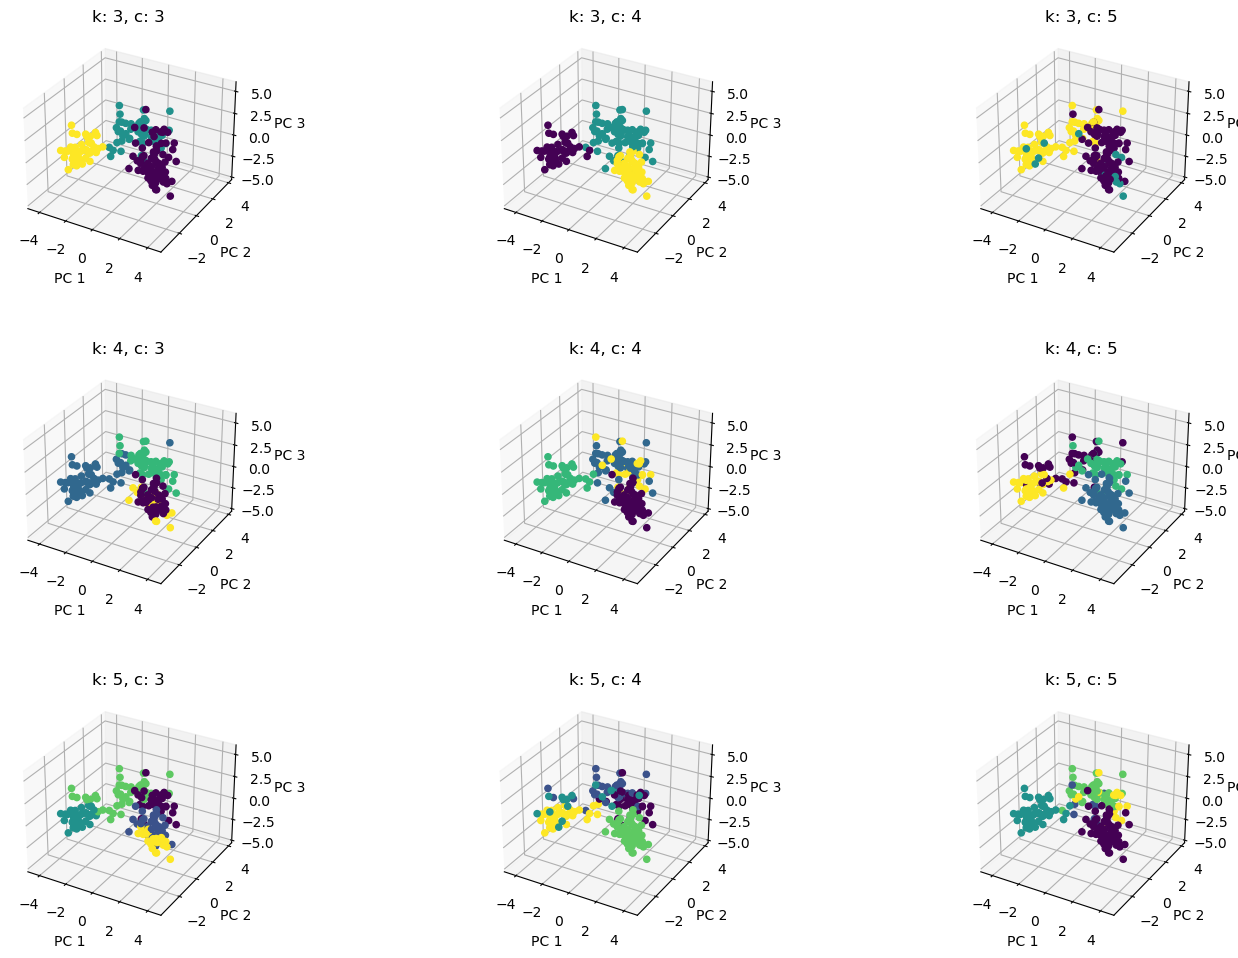

In [22]:
run_and_visualize(data, mixture_components, principal_components)

## 8. Running breast cancer wisconsin dataset

In [23]:
bcds = datasets.load_breast_cancer()
data = bcds.data

In [24]:
mixture_components = [3, 4, 5]
principal_components = [3, 4, 5]

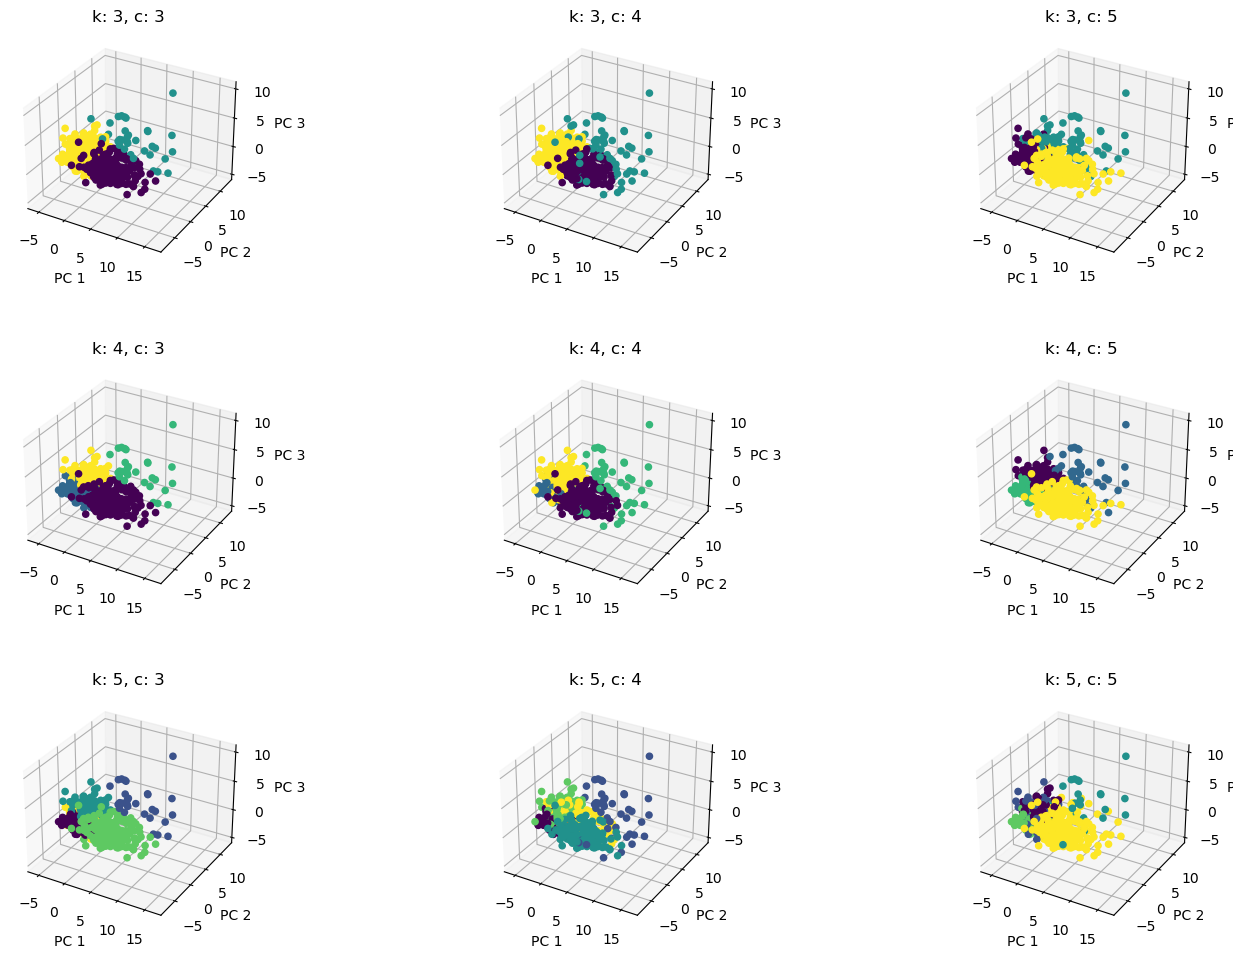

In [25]:
run_and_visualize(data, mixture_components, principal_components)

## 9. Comparsion against native sklearn GMM

In [26]:
wds = datasets.load_wine()
data = wds.data

In [27]:
mixture_components = [3, 4]
principal_components = [3, 4]

### sklearn native gmm

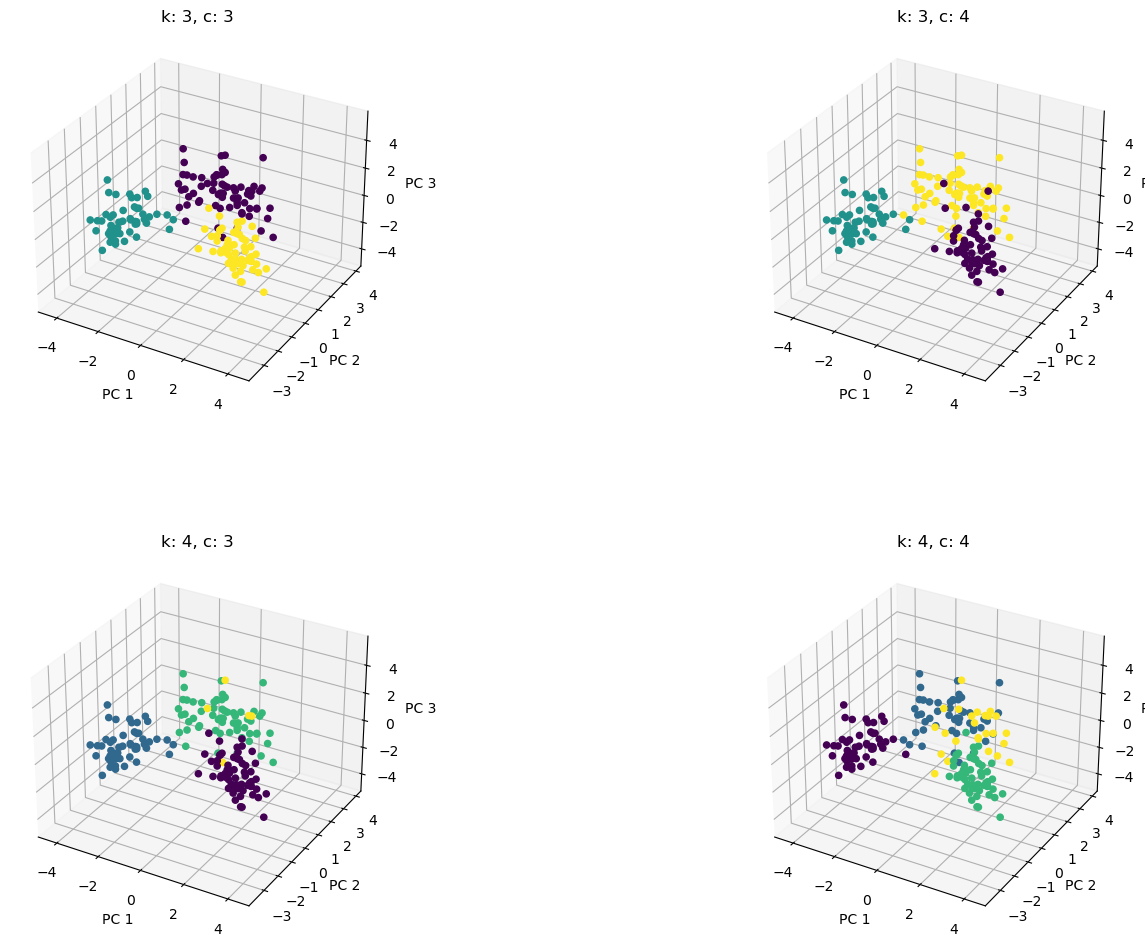

In [28]:
run_and_visualize(data, mixture_components, principal_components, my_implementation=False)

### my gmm

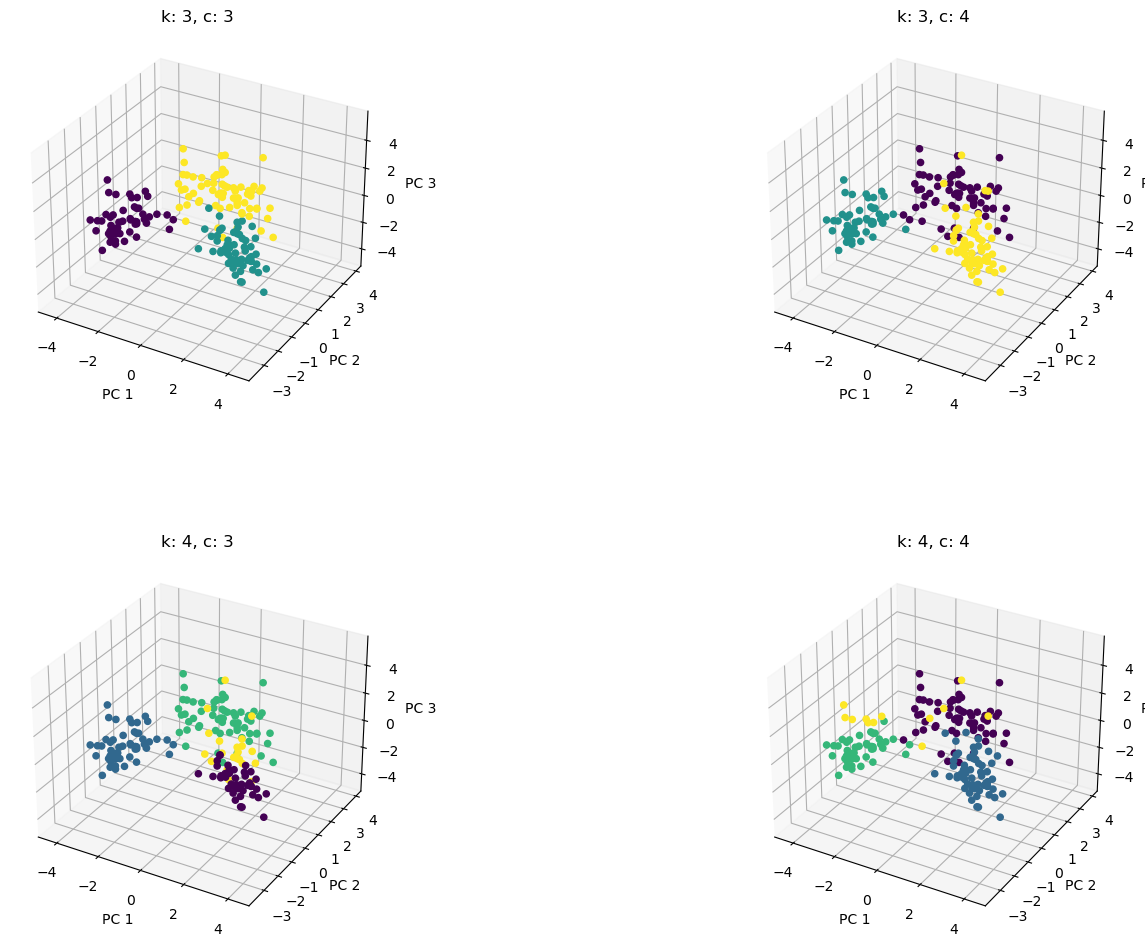

In [29]:
run_and_visualize(data, mixture_components, principal_components, my_implementation=True)

## 10. Report

### wine dataset analysis

It appears for the same number of principal components, a smaller number of mixture components performs better.

It appears for the same number of mixture components, the number of principal components does not dramatically affect the clustering.

### cancer dataset analysis

It appears for the same number of principal components, a smaller number of mixture components performs better.

It appears for the same number of mixture components, the number of principal components does not dramatically affect the clustering.

### comparison analysis

My GMM implementation is able to partition off clusters of similar structure as the native sklearn GMM.